In [1]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.resnet_v2 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16,VGG19,ResNet101V2
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score


# Defining the model 



*   Je vais  utiliser un dataset aribtraire, exemple : Flower dataset dans Kaggle après on change ça avec notre propore dataset 

*   Ajout de pooling pour réduire la dimension 
*   Utilisation d'un VGG au lieu d'un Resnet 
*   Réduire les dimesnions avec un PCA 
*   application de Kmeans pour culstering










In [2]:
model = ResNet101V2(include_top=True,weights='imagenet',input_shape=(224,224,3),pooling='max')

179527680/179518384 [==============================] - 2s 0us/step


In [3]:
model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [4]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls

drive  sample_data


In [7]:
base_dir = "/content/drive/My Drive/PMA"

In [8]:
samples = []

list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(base_dir, x)),
                        os.listdir(base_dir) ) )
for file in list_of_files : 
  if file.endswith('.jpg'):
    samples.append(file)

In [9]:
len(samples)

2908

# Data Preprocessing

In [10]:
import os
os.chdir(base_dir)

img = load_img(samples[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)


(224, 224, 3)


In [11]:
# reshaping the images 
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [12]:

def get_features(file, model):
    # get l'image  224x224 
    img = load_img(file, target_size=(224,224))
    # convertir l'image en numpy
    img = np.array(img) 
    # batch_size = 1, taille = 224x224 , channel = 3
    reshaped_img = img.reshape(1,224,224,3) 
    # passage vers le modele
    imgx = preprocess_input(reshaped_img)
    # get le vecteur de feature
    features = model.predict(imgx, use_multiprocessing=True)
    return features


In [13]:
# boucle sur l'ensemble des images

data = {}

for flower in samples:
  feat = get_features(flower,model)
  data[flower] = feat

filenames = np.array(list(data.keys()))

# liste des features
feat = np.array(list(data.values()))
feat.shape



(2908, 1, 2048)

In [14]:
feat = feat.reshape(-1,2048)
feat.shape

(2908, 2048)

# PCA

In [15]:
#application de PCA
pca = PCA(n_components=150, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

# Kmeans 




In [37]:
kmeans = KMeans(n_clusters=143,init='k-means++')
kmeans.fit(x)

KMeans(n_clusters=143)

In [38]:
kmeans.labels_


array([130, 140,   7, ...,  19, 120,  40], dtype=int32)

In [18]:


def cluster_groups(kmeans): 
  groups = {}
  for file, cluster in zip(filenames,kmeans.labels_):
      if cluster not in groups.keys():
          groups[cluster] = []
          groups[cluster].append(file)
      else:
          groups[cluster].append(file)
  return groups 
  

In [19]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    
    # Afficher chaque image dans son cluster 
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
view_cluster(0)


NameError: ignored

<Figure size 1800x1800 with 0 Axes>

In [ ]:
view_cluster(9)
groups[9]

In [ ]:
view_cluster(3)
groups[3]

# Defining metrics 

Num cluster  36  Silhoutte score   =  0.0719455
Num cluster  64  Silhoutte score   =  0.0673292
Num cluster  144  Silhoutte score   =  0.07457673
Num cluster  200  Silhoutte score   =  0.07880024
Num cluster  500  Silhoutte score   =  0.10543454
Num cluster  1000  Silhoutte score   =  0.12267409


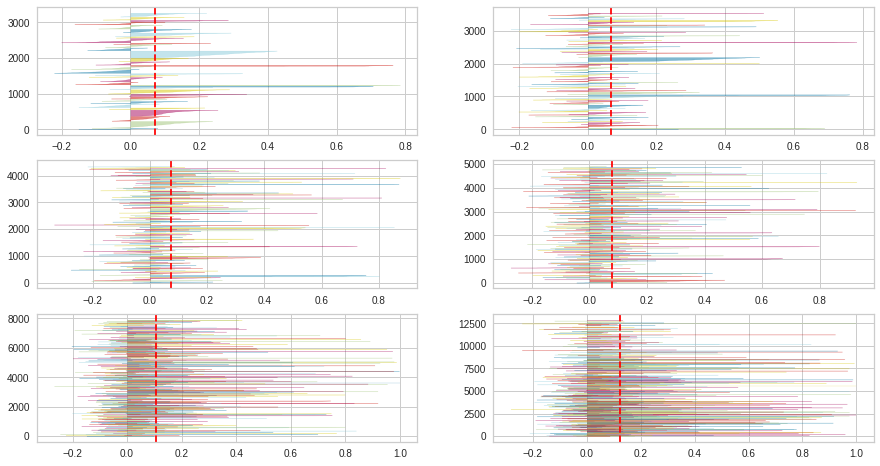

In [ ]:


clusters = [36, 64,144,200,500,1000]
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
j = 2
for i in clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', max_iter=100)
    km.fit(x)
    score = silhouette_score(x, km.labels_, metric='euclidean')
    print('Num cluster ',i,' Silhoutte score   = ',score)
    q, mod = divmod(j, 2)
    j+=1
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x)


In [39]:
groups = cluster_groups(kmeans)
num_cluster = [len(groups[i]) for i in groups.keys()]
num_cluster

[25,
 18,
 21,
 14,
 20,
 22,
 21,
 23,
 37,
 36,
 30,
 12,
 34,
 35,
 24,
 47,
 26,
 47,
 39,
 30,
 2,
 36,
 23,
 19,
 32,
 38,
 100,
 11,
 38,
 25,
 24,
 44,
 27,
 20,
 30,
 35,
 19,
 26,
 34,
 22,
 58,
 31,
 14,
 38,
 31,
 23,
 21,
 8,
 27,
 35,
 14,
 18,
 22,
 16,
 30,
 17,
 18,
 37,
 33,
 20,
 16,
 24,
 14,
 29,
 18,
 22,
 21,
 23,
 8,
 15,
 24,
 24,
 9,
 14,
 21,
 8,
 11,
 18,
 17,
 15,
 25,
 9,
 18,
 9,
 19,
 47,
 11,
 24,
 21,
 10,
 32,
 22,
 19,
 39,
 10,
 21,
 13,
 24,
 36,
 24,
 27,
 30,
 34,
 17,
 30,
 20,
 13,
 20,
 11,
 5,
 20,
 6,
 7,
 22,
 7,
 22,
 6,
 8,
 5,
 5,
 16,
 15,
 8,
 12,
 4,
 5,
 13,
 2,
 8,
 1,
 5,
 5,
 8,
 2,
 2,
 2,
 2,
 5,
 5,
 3,
 5,
 3,
 1]

In [ ]:
view_cluster(0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(4)

Output hidden; open in https://colab.research.google.com to view.

ValueError: ignored

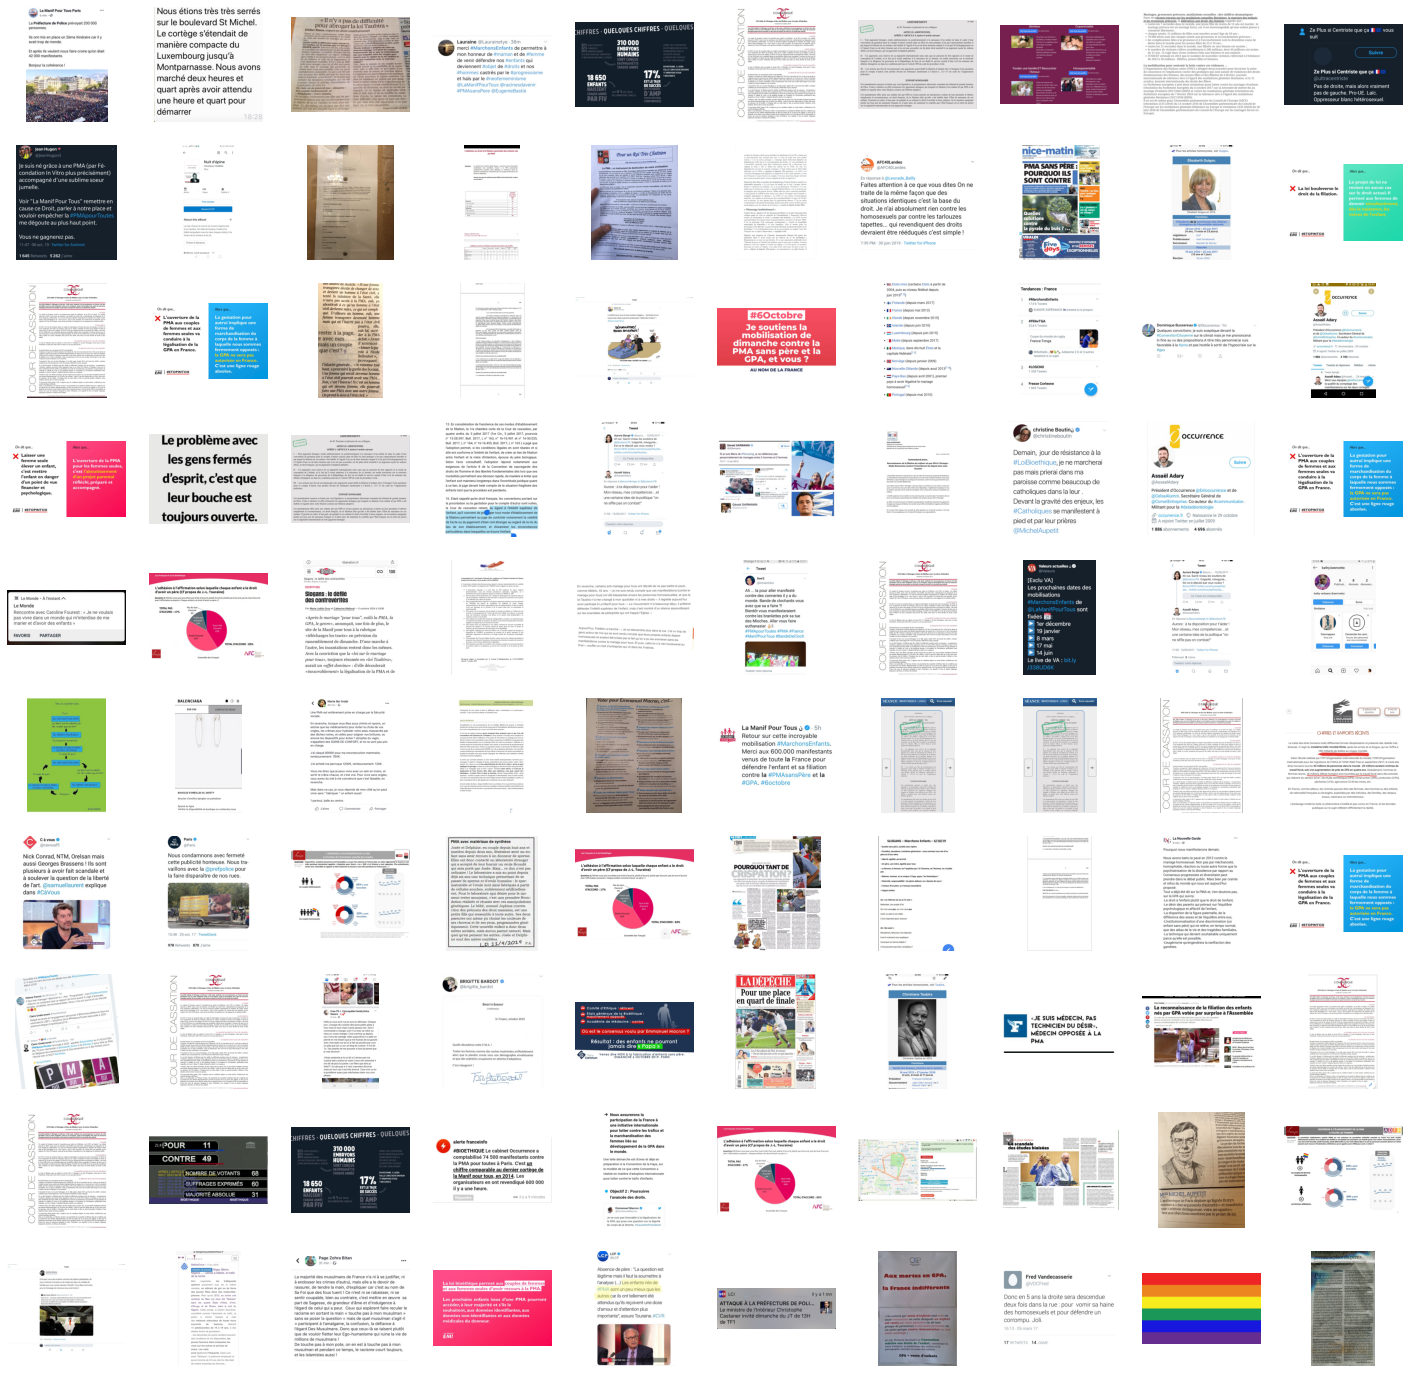

In [ ]:
view_cluster(5)

In [ ]:
view_cluster(6)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(7)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(8)

Output hidden; open in https://colab.research.google.com to view.

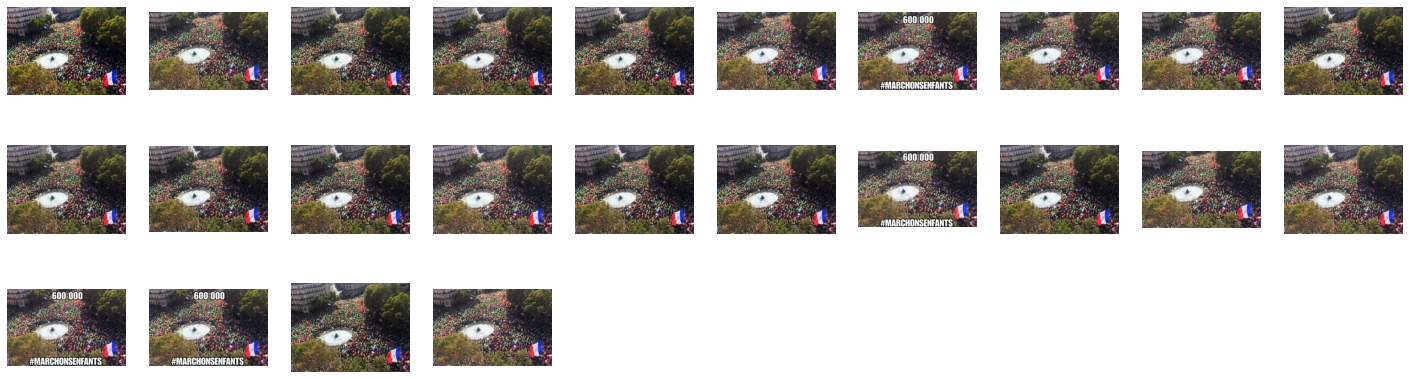

In [ ]:
view_cluster(9)

In [41]:
textfile = open("files_1.txt", "w")
for element in groups.values():
  textfile. write(str(element) + "\n")
